Assignment on Graph Neural Networks in the course Advanced machine learning using neural networks (Chalmers and University of Gothenburg). 

The objective is to train a GNN that works as a graph classifier on the provided data. The data comes from simulations of a 25 qubit quantum memory (surface code) with individual error rates of 5% per cycle of measurements (see assignment text for a little more detail). Since the data consists of graphs with varying number of nodes the way to implement the classifier is to make a graph embedding, i.e. a mapping of each graph to a vector of fixed size. This can then be used for classification. The typical structure would be Graph data-> Graph (convolution or other) layers -> Pooling -> Dense classifier. 

For this data the classification accuracy of the standard graph algorithm based decoder (minimum weight perfect matching) is 0.983. It may be hard to reach this without an even larger dataset, but it can serve as a target. Anything above an accuracy of 0.95 is acceptable. (This means that the quantum memory has a lower failure rate than the individual qubits, which is set at 5% to generate the data.)

In [ ]:
import os
import torch
os.environ['TORCH'] = torch.__version__
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 84.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 70.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


Some suggested GNN layers, you're welcome to try other.   

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch_geometric
from torch_geometric.loader import DataLoader
import torch_geometric.utils as utils
import networkx as nx
from torch.nn import Linear
from torch_geometric.nn import global_mean_pool, GraphConv, GATConv, GCNConv

%config InlineBackend.figure_format = 'svg'

The following shows how to load the data if it's available in your Google drive

In [ ]:
#If the data is available in your Google drive: 
from google.colab import drive
drive.mount('/content/drive')

# from google.colab import files
# upload = files.upload()
# dataset = torch.load('graph_data_decoding_2023.pt')

Mounted at /content/drive


In [ ]:
#It's a quite big dataset, so may take a few minutes
dataset = torch.load('/content/drive/MyDrive/graph_data_decoding_2023.pt')

Properties of the graphs

In [ ]:
print('====================')
print(f'Number of graphs: {len(dataset)}')
print('=============================================================')
data = dataset[20]  # Get one data point.

print('Some properties of a graph in the dataset:')
print()

print(data)
# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')
print(f'Number of node features: {data.num_node_features}')



Number of graphs: 1000000
Some properties of a graph in the dataset:

Data(x=[5, 4], edge_index=[2, 20], edge_attr=[20, 1], y=[1, 2])
Number of nodes: 5
Number of edges: 20
Average node degree: 4.00
Has isolated nodes: False
Has self-loops: False
Is undirected: True
Number of node features: 4


Note that the label y, is given by a tensor with 2 elements, giving a binary representation of the predicted equivalence class.  

*   00 <-> class I
*   10 <-> class X
*   01 <-> class Z
*   11 <-> class Y

The loss can either be constructed using two spearate classifiers, one for X and one for Z, or combined into one over all four classes. Either should work.



In [ ]:
label=data.y
label_X=label[:,0]
label_Z=label[:,1]
print(label_X,label_Z)
#The data point dataset[20] is thus in class X

tensor([1.]) tensor([0.])


In [ ]:
# edge_index is a tensor that represents the edges in the graph. It is a 2D tensor of shape (2, num_edges), where num_edges is the total number of edges in the graph.

The data consists of 4-dimensional feature vector per node, and each edge comes with a scalar weight.   

In [ ]:
edge_index = data.edge_index.t()
edge_index=edge_index.numpy()
feature=data.x.numpy()
edge=data.edge_attr.numpy()
print(edge_index)
print("----------------------------------")
print(edge)
# print(feature)

[[0 1]
 [0 2]
 [0 3]
 [0 4]
 [1 0]
 [1 2]
 [1 3]
 [1 4]
 [2 0]
 [2 1]
 [2 3]
 [2 4]
 [3 0]
 [3 1]
 [3 2]
 [3 4]
 [4 0]
 [4 1]
 [4 2]
 [4 3]]
----------------------------------
[[1.        ]
 [0.25      ]
 [0.25      ]
 [0.11111111]
 [1.        ]
 [0.25      ]
 [1.        ]
 [0.11111111]
 [0.25      ]
 [0.25      ]
 [0.25      ]
 [1.        ]
 [0.25      ]
 [1.        ]
 [0.25      ]
 [0.11111111]
 [0.11111111]
 [0.11111111]
 [1.        ]
 [0.11111111]]


In [ ]:
graph = dataset[20]
g = utils.to_networkx(graph, to_undirected=True)
positions = {}
label_positions = {}
node_labels = {}
edge_labels={}
x = graph.x
for i in range(x.shape[0]):
    positions[i] = np.array([x[i, 2], x[i, 3]])
    label_positions[i] = np.array([x[i, 2], x[i, 3]])
    node_labels[i] = np.array([x[i, 0], x[i, 1], x[i, 2], x[i, 3]])
for i in range(edge_index.shape[0]):
    edge_labels[(edge_index[i,0],edge_index[i,1])]=edge[i]

(-0.04200000062584877,
 0.4420000065863133,
 0.3370000049471855,
 1.063000001013279)

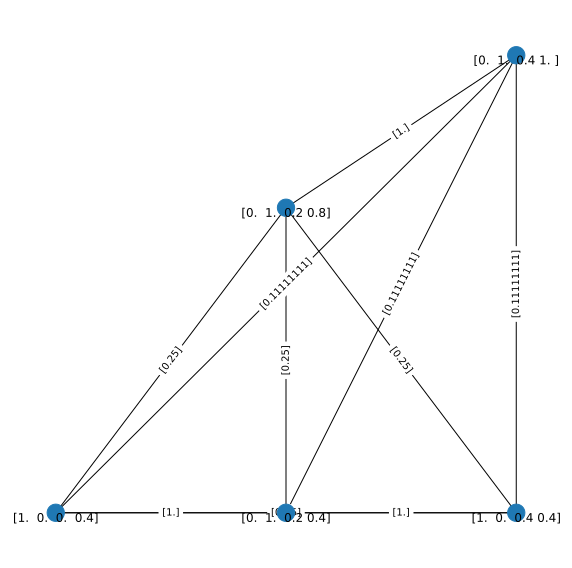

In [ ]:
fig, ax = plt.subplots(figsize = (10, 10))
nx.draw_networkx(g, ax=ax, pos = positions, labels = node_labels, with_labels = False)
nx.draw_networkx_labels(g, ax=ax, pos = label_positions, labels = node_labels, verticalalignment= 'top')
nx.draw_networkx_edge_labels(g,ax=ax,  pos = positions,edge_labels=edge_labels)
ax.axis('off')

In [ ]:
# split the dataset into test and validation:
num_samples = len(dataset)
print(num_samples)


1000000


In [ ]:
train_data = dataset[int(.05 * num_samples ) :] # 95% train
test_data = dataset[: int(.05 * num_samples )] # 5% test
print("Number of training graphs: ",len(train_data))
print("Number of test graphs: ",len(test_data))


Number of training graphs:  950000
Number of test graphs:  50000


In [ ]:
train_loader = DataLoader(train_data, batch_size=1000, shuffle=True)
test_loader = DataLoader(test_data, batch_size=1000, shuffle=True)

for step, data_enum in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data_enum.num_graphs}')
    print(data_enum)
    print()

Step 1:
Number of graphs in the current batch: 1000
DataBatch(x=[3391, 4], edge_index=[2, 11564], edge_attr=[11564, 1], y=[1000, 2], batch=[3391], ptr=[1001])

Step 2:
Number of graphs in the current batch: 1000
DataBatch(x=[3458, 4], edge_index=[2, 11960], edge_attr=[11960, 1], y=[1000, 2], batch=[3458], ptr=[1001])

Step 3:
Number of graphs in the current batch: 1000
DataBatch(x=[3360, 4], edge_index=[2, 11458], edge_attr=[11458, 1], y=[1000, 2], batch=[3360], ptr=[1001])

Step 4:
Number of graphs in the current batch: 1000
DataBatch(x=[3437, 4], edge_index=[2, 11746], edge_attr=[11746, 1], y=[1000, 2], batch=[3437], ptr=[1001])

Step 5:
Number of graphs in the current batch: 1000
DataBatch(x=[3399, 4], edge_index=[2, 11754], edge_attr=[11754, 1], y=[1000, 2], batch=[3399], ptr=[1001])

Step 6:
Number of graphs in the current batch: 1000
DataBatch(x=[3327, 4], edge_index=[2, 10938], edge_attr=[10938, 1], y=[1000, 2], batch=[3327], ptr=[1001])

Step 7:
Number of graphs in the current 

In [ ]:
from torch_geometric.nn import global_mean_pool, GCNConv
import torch.nn.functional as F
import copy

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GraphConv(data.num_node_features, 2*hidden_channels)
        self.conv2 = GraphConv(2*hidden_channels, 4*hidden_channels)
        self.conv3 = GraphConv(4*hidden_channels, 2*hidden_channels)
        self.conv4 = GraphConv(2*hidden_channels, hidden_channels)
        # self.lin1 = Linear(hidden_channels, hidden_channels)
        self.lin1 = Linear(hidden_channels, 2)

    def forward(self, x, edge_index, edge_attr, batch):
        x = self.conv1(x, edge_index, edge_weight=edge_attr)
        x = x.relu()
        x = self.conv2(x, edge_index, edge_weight=edge_attr)
        x = x.relu()
        x = self.conv3(x, edge_index, edge_weight=edge_attr)
        x = x.relu()
        x = self.conv4(x, edge_index, edge_weight=edge_attr)
        # x = x.relu()

        x = global_mean_pool(x, batch)
        
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin1(x)
        # x = self.lin2(x)
        
        return x

gcn_model = GCN(hidden_channels=16)
print(gcn_model)

GCN(
  (conv1): GraphConv(4, 32)
  (conv2): GraphConv(32, 64)
  (conv3): GraphConv(64, 32)
  (conv4): GraphConv(32, 16)
  (lin1): Linear(in_features=16, out_features=2, bias=True)
)


In [ ]:
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

gcn_model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(gcn_model.parameters(), lr=0.005)
criterion = torch.nn.BCEWithLogitsLoss()


def train():
      gcn_model.train()
      for data in train_loader:
            out = gcn_model(data.x, data.edge_index, data.edge_attr, data.batch)
            loss = criterion(out, data.y)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
      return loss

def test():
    gcn_model.eval()
    correct_train = 0
    correct_test = 0
    
    # concatenate train and test datasets
    train_data_loader = DataLoader(train_loader.dataset, batch_size=train_loader.batch_size, shuffle=True)
    test_data_loader = DataLoader(test_loader.dataset, batch_size=test_loader.batch_size, shuffle=False)
    
    # print("----Training - start----")
    for data in train_data_loader:
        out = gcn_model(data.x, data.edge_index, data.edge_attr, data.batch)
        out = torch.heaviside(out, torch.tensor([0.0]))
        correct = torch.all(out == data.y, dim=1).sum().item()
        correct_train += correct
        # print(correct_train)
    # print("----Training - end----")

    # print("----Testing - start----")
    for data in test_data_loader:
        out = gcn_model(data.x, data.edge_index, data.edge_attr, data.batch)
        out = torch.heaviside(out, torch.tensor([0.0]))
        correct = torch.all(out == data.y, dim=1).sum().item()
        correct_test += correct
        # print(correct_train)
    # print("----Testing - end----")
    
    return correct_train, correct_test



<IPython.core.display.Javascript object>

In [ ]:
for epoch in range(1, 26):
    loss = train()
    correct_train, correct_test = test()
    train_acc = correct_train / len(train_loader.dataset)
    test_acc = correct_test / len(test_loader.dataset)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')


Epoch: 001, Loss: 0.0751, Train Acc: 0.9565, Test Acc: 0.9555
Epoch: 002, Loss: 0.0479, Train Acc: 0.9621, Test Acc: 0.9614
Epoch: 003, Loss: 0.0628, Train Acc: 0.9652, Test Acc: 0.9647
Epoch: 004, Loss: 0.0648, Train Acc: 0.9655, Test Acc: 0.9643
Epoch: 005, Loss: 0.0594, Train Acc: 0.9681, Test Acc: 0.9675
Epoch: 006, Loss: 0.0541, Train Acc: 0.9697, Test Acc: 0.9689
Epoch: 007, Loss: 0.0472, Train Acc: 0.9710, Test Acc: 0.9701
Epoch: 008, Loss: 0.0393, Train Acc: 0.9722, Test Acc: 0.9710
Epoch: 009, Loss: 0.0467, Train Acc: 0.9731, Test Acc: 0.9728
Epoch: 010, Loss: 0.0582, Train Acc: 0.9737, Test Acc: 0.9728
Epoch: 011, Loss: 0.0393, Train Acc: 0.9732, Test Acc: 0.9729
Epoch: 012, Loss: 0.0439, Train Acc: 0.9757, Test Acc: 0.9753
Epoch: 013, Loss: 0.0325, Train Acc: 0.9752, Test Acc: 0.9750
Epoch: 014, Loss: 0.0314, Train Acc: 0.9762, Test Acc: 0.9762
Epoch: 015, Loss: 0.0405, Train Acc: 0.9755, Test Acc: 0.9759
Epoch: 016, Loss: 0.0365, Train Acc: 0.9758, Test Acc: 0.9760
Epoch: 0